In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

In [15]:
class Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = transforms.ToTensor()(mask)
        return image, mask

In [60]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, padding=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [61]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = Dataset(
    image_dir='imageset/pond_before/',
    mask_dir='imageset/pond_after',
    image_transform=image_transform,
    mask_transform=mask_transform
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [62]:
model = CNN()
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [64]:
num_epochs = 20
for epoch in range(num_epochs):
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.0625959038734436
Epoch 2, Loss: 0.053936708718538284
Epoch 3, Loss: 0.06278480589389801
Epoch 4, Loss: 0.059040069580078125
Epoch 5, Loss: 0.04695013538002968
Epoch 6, Loss: 0.05132019892334938
Epoch 7, Loss: 0.05548706278204918
Epoch 8, Loss: 0.05609874427318573
Epoch 9, Loss: 0.04854048043489456
Epoch 10, Loss: 0.0482042171061039
Epoch 11, Loss: 0.036979179829359055
Epoch 12, Loss: 0.04496987164020538
Epoch 13, Loss: 0.035793766379356384
Epoch 14, Loss: 0.04820415750145912
Epoch 15, Loss: 0.04288116842508316
Epoch 16, Loss: 0.035840339958667755
Epoch 17, Loss: 0.03935669735074043
Epoch 18, Loss: 0.04088990390300751
Epoch 19, Loss: 0.05302787944674492
Epoch 20, Loss: 0.03941693156957626


In [65]:
torch.save(model.state_dict(), 'segmentation_model.pth')

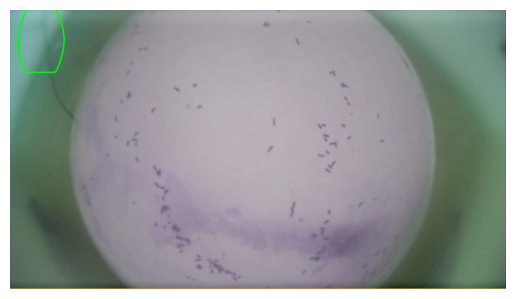

In [66]:
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, padding=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_transformed = transform(image)
    image_batch = image_transformed.unsqueeze(0)
    
    return image_batch

def predict_mask(model, image_batch):
    model.eval()
    with torch.no_grad():
        prediction = model(image_batch)
        predicted_mask = prediction > 0.5
    return predicted_mask.squeeze().cpu().numpy()

def highlight_circle(original_image, predicted_mask):
    mask_uint8 = (predicted_mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    highlighted_image = original_image.copy()
    cv2.drawContours(highlighted_image, contours, -1, (0, 255, 0), 3)
    
    return highlighted_image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_path = 'imageset/pond_before/1.png'

model = CNN() 
model.load_state_dict(torch.load('segmentation_model.pth'))

image_batch = process_image(image_path)
predicted_mask = predict_mask(model, image_batch)

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

highlighted_image = highlight_circle(original_image, predicted_mask)

plt.imshow(highlighted_image)
plt.axis('off')
plt.show()
